In [1]:
import networkx as nx  # pip3 install networkx==2.3
import pandas as pd
import numpy as np
import pickle
from scipy import stats
import math
import os

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import binarize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import operator
from operator import itemgetter
import matplotlib.ticker as tick
import statsmodels.api as sm
import scikitplot as skplt
from sklearn.metrics import confusion_matrix
import itertools
from markdown import markdown

---

## Link Prediction UTS

Facebook Competition Emails

Link prediction is a thoroughly studied yet challenging task in Network science. You can find an introduction to link prediction and several methods for solving link prediction [here](https://hackernoon.com/link-prediction-in-large-scale-networks-f836fcb05c88).

The dataset consists of 1000 nodes and a submission requires a list of all possible edges with a label for whether the edge is "active". If there is an edge exists in the graph, we say it is 'active', indicated by a 1 in the data. If the edge does not exist in the graph, we call it 'inactive', this is indicated by a 0 in the data.

The goal in this competition is to predict which edges (aka links) will appear in the next time step. 

We will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

References:  
1.$Gulliaume\ Le\ Floch$, [Link Predictions in Large Scale Networks](https://hackernoon.com/link-prediction-in-large-scale-networks-f836fcb05c88).  
2.$kaggle$, [Link Prediction UTS on kaggle - Predict the links occurring in next time step](https://www.kaggle.com/c/link-prediction-uts/overview).

In [2]:
data = pd.read_csv('email_prediction_edges.csv')
data.columns = ['edge_id', 'u', 'v']
data.set_index('edge_id', inplace=True)
print(data.shape)

(16706, 2)


In [3]:
GraphType = nx.Graph()
#G = nx.from_pandas_edgelist(data.sample(2000), source='source_node', target='destination_node', create_using=GraphType)
#G = nx.from_pandas_edgelist(data[data['active']==1], source='u', target='v', create_using=GraphType)
G = nx.from_pandas_edgelist(data, source='u', target='v', create_using=GraphType)

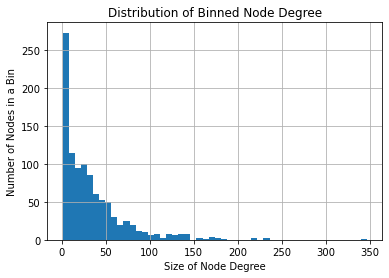

In [4]:
node_colors = [G.degree(v) for v in G]
node_sizes = [G.degree(v) for v in G]
#print(node_sizes)
pd.DataFrame(node_sizes).hist(bins=50)
# Add title and axis names
plt.title('Distribution of Binned Node Degree')
plt.xlabel('Size of Node Degree')
plt.ylabel('Number of Nodes in a Bin')
pyplot.show()

In [5]:
#G.nodes('415')
#G.degree('415')

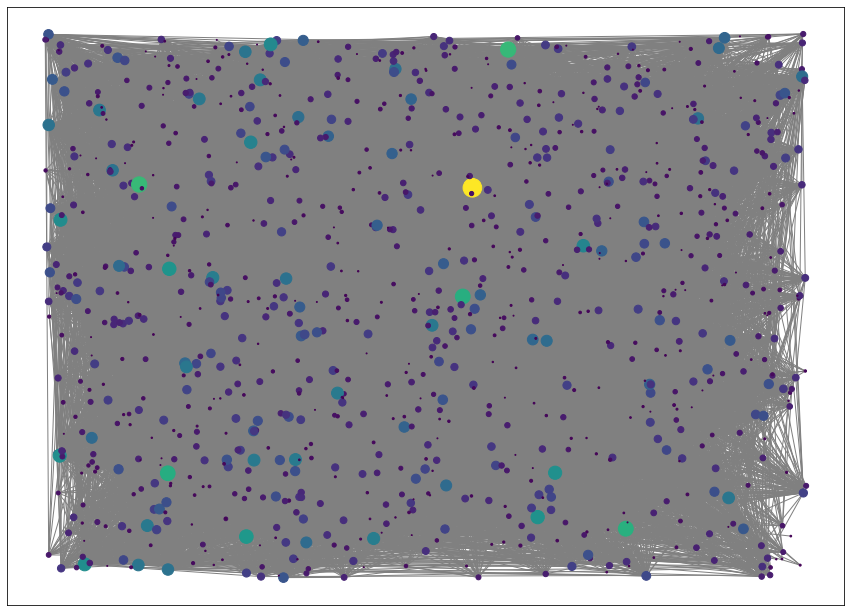

In [6]:
plt.figure(figsize=(15,11))
#pos = nx.spring_layout(G)
#pos = nx.circular_layout(G)
pos = nx.random_layout(G)
#node_sizes = [G.degree(v) for v in G]
nx.draw_networkx(G, pos, node_size = node_sizes, node_color = node_colors, with_labels=False,
                 edge_color='gray', edge_alpha=0.3, edge_tickness=0.1)

Largest Hub Node = 160 with degree of 347


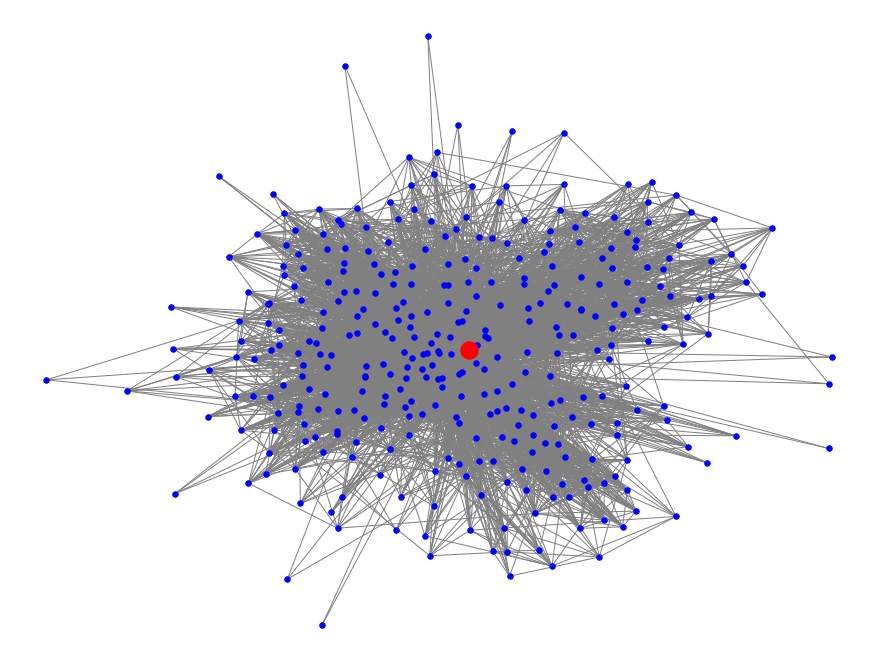

In [7]:
node_and_degree=G.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
print('Largest Hub Node = {} with degree of {}'.format(largest_hub, degree))
# Create ego graph of main hub
hub_ego=nx.ego_graph(G,largest_hub)
# Draw graph
plt.figure(figsize=(12,9))
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=30, edge_color='gray', edge_alpha=0.3, edge_tickness=0.1, with_labels=False)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options, with_labels=True)
#plt.savefig('ego_graph.png')
plt.show()

Node = 274 with degree of 23


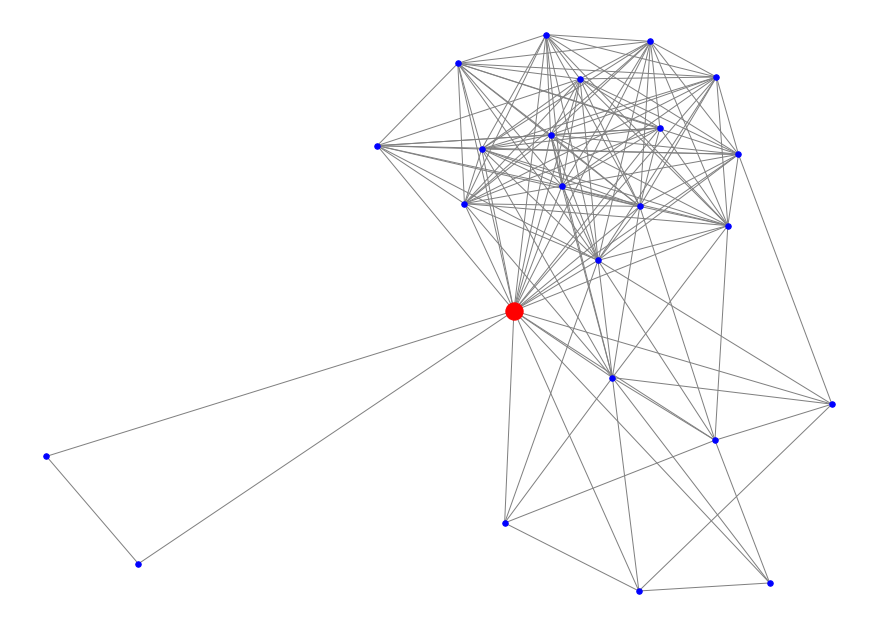

In [8]:
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-500]  #500
print('Node = {} with degree of {}'.format(largest_hub, degree))
# Create ego graph of main hub
hub_ego=nx.ego_graph(G,largest_hub)
# Draw graph
plt.figure(figsize=(12,8.5))
pos = nx.random_layout(hub_ego)
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=30, edge_color='gray', edge_alpha=0.3, edge_tickness=0.1, with_labels=False)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options, with_labels=True)
#plt.savefig('ego_graph.png')
plt.show()

In [9]:
#itemgetter(node_and_degree, '274')

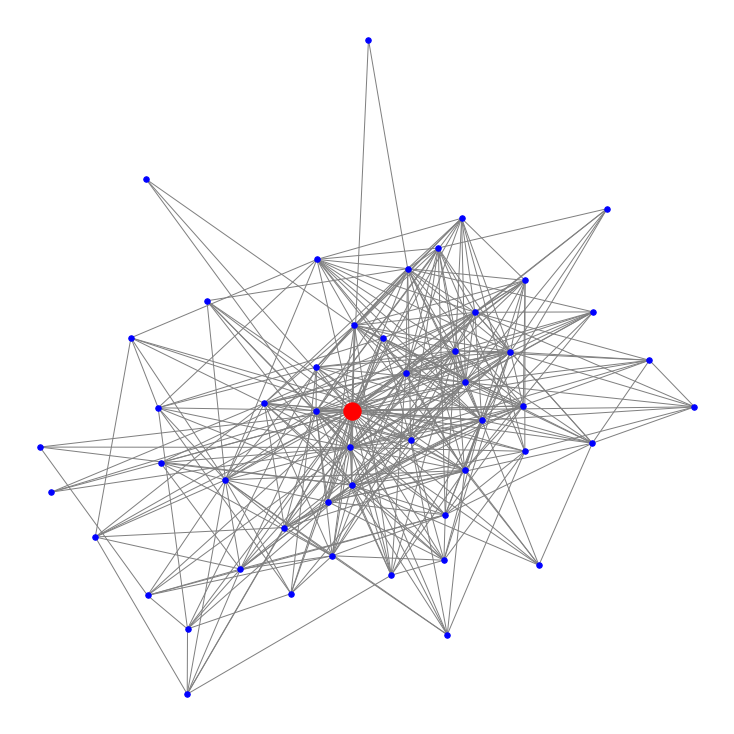

In [10]:
hub_node = 1
hub_ego=nx.ego_graph(G,hub_node)
# Draw graph
plt.figure(figsize=(10,10))
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=30, edge_color='gray', edge_alpha=0.3, edge_tickness=0.1, with_labels=False)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[hub_node], **options, with_labels=True)
#plt.savefig('ego_graph.png')
plt.show()

In [11]:
#non_edges =
df = pd.DataFrame()
df = pd.DataFrame(index=nx.non_edges(G))
df.shape

(488446, 0)

## Feature Engineering for Supervised Learning

Now we will define and extract features in order to perform Supervised Learning (Binary Classification). Based on Kolja Esders’s work in his Bachelor’s Thesis at the Karlsruhe Institute of Technologyn (2015) [Link Prediction in Large-scale Complex Networks](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiooafj3eHsAhUGonIEHZhMCxoQFjAEegQIARAC&url=https%3A%2F%2Fwww.theses.fr%2F2015USPCD010.pdf&usg=AOvVaw0Zq3xuOtw33UcjbYEQqJWV), we will use unsupervised scores as features for our predictive model. We will also use the notion of Community and further details can be found in [Fast unfolding of communities in large networks](https://arxiv.org/pdf/0803.0476.pdf) by Vincent D. Blondel, Jean-Loup Guillaume, Renaud Lambiotte and Etienne Lefebvre in 2008.

The following features will be included in our learning/prediction task : Common Neighbors Index($CNI$), Jaccard Coefficient Index($JCI$), Adamic-Adar Index ($AAI$), Resource Allocation Index($RAI$), Preferential Attachement Index($PAI$), Adjusted-Rand Index($ARI$), Neighborhood Distance Index($NDI$), Total Neighbors Index($TNI$), Node Degree Index($UDI$ or $VDI$) and Same Community ($SCI$) features. Let $\Gamma(u)$ be the set of neighbors of node $u$. Then we can define them as follows:

$$CNI(u,v) = | \Gamma (u) \cap \Gamma (v) | \text{, defining common neighbors of node } u \text{ and } v$$

$$JCI(u,v) = \frac{| \Gamma (u) \cap \Gamma (v) |}{| \Gamma (u) \cup \Gamma (v) |} \text{, defining Jaccard's coefficient of node } u \text{ and } v, \text{or normalizing } CN(u,v)$$

$$RAI(u,v) = \sum_{w \in \Gamma (u) \cap \Gamma (v)} \frac{1}{| \Gamma (w) |} \text{, fraction of a "resource" a node sending to another through their common neighbors}$$

$$AAI(u,v) = \sum_{w \in \Gamma (u) \cap \Gamma (v)} \frac{1}{log(| \Gamma (w) |)} \text{, defining Adamic-Adar index of node } u \text{ and } v, \text{or log-version of } RA(u,v)$$

$$PAI(u,v) = | \Gamma (u) | \times | \Gamma (v) |\text{, defining Perferential Attachment index of node } u \text{ and } v, \text{or nodes with higher degree get more neighbors} $$

$$ARI(u,v) = \frac{2(ad-bc)}{(a+b)(b+d)+(a+c)(c+d)} \text{, where } a,b,c \text{ and } d \text{ will be defined below}$$

$$NDI(u,v) = \frac{| \Gamma (u) \cap \Gamma (v) |}{\sqrt{| \Gamma (u) | \times | \Gamma (v) |}}\text{, defining neighborhood distance of node } u \text{ and } v$$

$$TNI(u,v) = | \Gamma (u) \cup \Gamma (v) | \text{, defining total neighbors of node } u$$

$$\ UNI(u,v) = | \Gamma (u) |,\text{ and } VNI(u,v) = | \Gamma (v) | \text{, defining neighbors of node } u \text{ and } v, \text{ respectively}  $$

$$SCI(u,v) = 1 \text{ if } u \text{ and } v \text{ belongs to the same community, } 0 \text{ otherwise}$$

In [12]:
#edge_mat = graph_to_edge_matrix(G)
#edge_mat

Reference: [A Note on Using the Adjusted Rand Index for Link Prediction in Networks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6191196/), Michaela Hoffman, Douglas Steinley, and Michael J. Brusco.

To introduce general notation for a network, assume $n_i$ is the $i^{th}$ object, and $i = 1, \dots , N$. Frequently, network information is collected in the adjacency matrix, $A_{N×N} = \{ a_{ij} \}$, where $A$ is a square $N × N$ matrix that represents the connections between all pairs of objects. Specifically, $a_{ij} = 1$ if $n_i$ is connected to $n_j$; otherwise, $a_{ij} = 0$. This information can be summarized in row vectors corresponding to the $i^{th}$ and $j^{th}$ row in $A$, $(a_i)^′$ and $(a_j)^′$, (where each are $1 × n$ vectors, respectively).

If one considers the similarity between $n_i$ and $n_j$, there are four possible “states” for binary vectors that can be computed when considering the mutual pattern of connections between $n_i$ and $n_j$ when related to all of the other remaining nodes. The counts of these states gives us four quantities:  
 - the number of links to other nodes $n_m$ that $n_i$ and $n_j$ have in common, $a$,
 - the number of times that $n_i$ has links to other nodes $n_m$, and $n_j$ does not, $b$,
 - the number of times that $n_i$ does not have links to other nodes $n_m$, but $n_j$ does, $c$, and  
 - the number of times that links to other nodes $n_m$ are mutually absent for $n_i$ and $n_j$, $d$.   
For any pair of row vectors, (a_i)^′$ and $(a_j)^′$ in the adjacency matrix the four quantities can be quickly computed from the following inner products:

$a=(a_i)^′ a_j$, $b=(a_i)^′(1−a_j)$, $c=(1-a_i)′ a_j$, and $d=(1−a_i)′(1−a_j)$.  

Often, these four values are collected in a simple $2 × 2$ contingency table, as indicated in the following Table. The values of this contingency table are combined in various ways to form similarity or proximity measures. Four proximity measures currently used for link prediction studies are described in the next section, three of which are calculated from the proximity table.

The contingency table for each pair of nodes $n_i$ and $n_j$ across all other nodes $n_m$.

| Node $n_j$ --- Node $n_i$ | Linked to Node $n_m$ | Not Linked to Node $n_m$ |
| ---: | :--: | :--: |
| Linked to Node $n_m$ |  _a_ | _b_ |
| Not Linked to Node $n_m$ | _c_ | _d_ |

Let's transform our graph into a matrix and print the result to see what it contains:

Reference: [K-Means & Other Clustering Algorithms: A Quick Intro with Python](https://www.learndatasci.com/tutorials/k-means-clustering-algorithms-python-intro/), Nikos Koufos and Brendan Martin.

In [13]:
def graph_to_edge_matrix(G):
    # Initialize edge matrix with zeros
    edge_mat = np.zeros((len(G), len(G)), dtype=int)

    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node in G:
        for neighbor in G.neighbors(node):
            edge_mat[node][neighbor] = 1
        edge_mat[node][node] = 1

    return edge_mat

In [14]:
def compute_adjusted_rand_index(G):
    edge_mat = graph_to_edge_matrix(G)
    # Initialize edge matrix with zeros
    data_AAI = np.zeros((len(G), len(G)), dtype=float)
    data_adj = np.array(edge_mat)
    for e in nx.non_edges(G):
        a = np.dot(data_adj[e[0]][:], data_adj[:][e[1]])
        b = np.dot(data_adj[e[0]][:], np.ones(len(G))-data_adj[:][e[1]])
        c = np.dot(np.transpose(np.ones(len(G)))-data_adj[e[0]][:], data_adj[:][e[1]])
        d = np.dot(np.transpose(np.ones(len(G)))-data_adj[e[0]][:], np.ones(len(G))-data_adj[:][e[1]])
        data_AAI[e[0]][e[1]] = (2*(a*d-b*c))/((a+b)*(b+d)+(a+c)*(c+d))

    return data_AAI
#compute_adjusted_rand_index(G)

In [15]:
def compute_Neighbor_Distance_index(G):
    # Initialize edge matrix with zeros
    data_NDI = np.zeros((len(G), len(G)), dtype=float)
    for e in nx.non_edges(G):
        a = G.degree(e[0])
        b = G.degree(e[1])
        c = len(list(nx.common_neighbors(G, e[0], e[1])))
        #print(a,b,c)
        data_NDI[e[0]][e[1]] = c/math.sqrt(a*b)

    return data_NDI
#compute_Neighbor_Distance_index(G)

In [16]:
def compute_Total_Neighbors_index(G):
    # Initialize edge matrix with zeros
    data_TNI = np.zeros((len(G), len(G)), dtype=int)
    for e in nx.non_edges(G):
        edges1 = set(G.edges(e[0]))
        edges2 = set(G.edges(e[1]))
        c = len(edges1.union(edges2))
        data_TNI[e[0]][e[1]] = c

    return data_TNI
#compute_Total_Neighbors_index(G)

In [17]:
def compute_Node_Degree_index(G):
    # Initialize edge matrix with zeros
    data_NDI = np.zeros(len(G), dtype=int)
    for e in nx.non_edges(G):
        data_NDI[e[0]] = G.degree(e[0])

    return data_NDI
#compute_Node_Degree_index(G)

In [18]:
def compute_Vertex_Degree_index(G):
    # Initialize edge matrix with zeros
    data_VDI = np.zeros(len(G), dtype=int)
    for e in nx.non_edges(G):
        data_VDI[e[1]] = G.degree(e[1])

    return data_VDI
#compute_Vertex_Degree_index(G)

In [19]:
# Common Neighbors
df['CNI'] = None
SMI = [((e[0], e[1]), len(list(nx.common_neighbors(G, e[0], e[1])))) for e in nx.non_edges(G)]
df2 = pd.DataFrame(SMI, columns=['Conn', 'CNI'])
df2.set_index('Conn', inplace=True)
df.update(df2)

# Jaccard Coefficient - Common Neighbors
df['JCI'] = None
SMI = [((e[0], e[1]), list(nx.jaccard_coefficient(G, [(e[0], e[1])]))[0][2]) for e in nx.non_edges(G)]
df2 = pd.DataFrame(SMI, columns=['Conn', 'JCI'])
df2.set_index('Conn', inplace=True)
df.update(df2)

# Resource Allocation Index
df['RAI'] = None
SMI = [((e[0], e[1]), list(nx.resource_allocation_index(G, [(e[0], e[1])]))[0][2]) for e in nx.non_edges(G)]
df2 = pd.DataFrame(SMI, columns=['Conn', 'RAI'])
df2.set_index('Conn', inplace=True)
df.update(df2)

# Adamic_Adar_Index
df['AAI'] = None
SMI = [((e[0], e[1]), list(nx.adamic_adar_index(G, [(e[0], e[1])]))[0][2]) for e in nx.non_edges(G)]
df2 = pd.DataFrame(SMI, columns=['Conn', 'AAI'])
df2.set_index('Conn', inplace=True)
df.update(df2)

# Preferentail Attachment - Product of the nodes' degree
df['PAI'] = None
SMI = [((e[0], e[1]), list(nx.preferential_attachment(G, [(e[0], e[1])]))[0][2]) for e in nx.non_edges(G)]
df2 = pd.DataFrame(SMI, columns=['Conn', 'PAI'])
df2.set_index('Conn', inplace=True)
df.update(df2)

# Adjusted Rand Index
df['ARI'] = None
data_SMI = compute_adjusted_rand_index(G)
SMI = []
for e in nx.non_edges(G):
    SMI.append(((e[0], e[1]), data_SMI[e[0]][e[1]]))
df2 = pd.DataFrame(SMI, columns=['Conn', 'ARI'])
df2.set_index('Conn', inplace=True)
df.update(df2)

# Meighborhood Distance
df['NDI'] = None
data_SMI = compute_Neighbor_Distance_index(G)
SMI = []
for e in nx.non_edges(G):
    SMI.append(((e[0], e[1]), data_SMI[e[0]][e[1]]))
df2 = pd.DataFrame(SMI, columns=['Conn', 'NDI'])
df2.set_index('Conn', inplace=True)
df.update(df2)

# Total Nodes
df['TNI'] = None
data_SMI = compute_Total_Neighbors_index(G)
SMI = []
for e in nx.non_edges(G):
    SMI.append(((e[0], e[1]), data_SMI[e[0]][e[1]]))
df2 = pd.DataFrame(SMI, columns=['Conn', 'TNI'])
df2.set_index('Conn', inplace=True)
df.update(df2)

# Node Degree of Vertex U
df['UDI'] = None
data_SMI = compute_Node_Degree_index(G)
SMI = []
for e in nx.non_edges(G):
    SMI.append(((e[0], e[1]), data_SMI[e[0]]))
df2 = pd.DataFrame(SMI, columns=['Conn', 'UDI'])
df2.set_index('Conn', inplace=True)
df.update(df2)

# Node Degree of Vertex V
df['VDI'] = None
data_SMI = compute_Vertex_Degree_index(G)
SMI = []
for e in nx.non_edges(G):
    SMI.append(((e[0], e[1]), data_SMI[e[1]]))
df2 = pd.DataFrame(SMI, columns=['Conn', 'VDI'])
df2.set_index('Conn', inplace=True)
df.update(df2)

In [20]:
# Preferentail Attachment - Product of the nodes' degree
print(df.shape)
df.head()

(488446, 10)


,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,UDI,VDI
"(0, 2)",6,0.0458015,0.0553402,1.25763,4180,0.0306788,0.0928032,137,44,95
"(0, 3)",3,0.0272727,0.0213876,0.605728,3124,9.29843e-05,0.0536742,113,44,71
"(0, 4)",3,0.0222222,0.0213876,0.605728,4224,-0.016396,0.0461593,138,44,96
"(0, 7)",4,0.0363636,0.0616678,0.938816,3168,0.0178308,0.0710669,114,44,72
"(0, 8)",1,0.0128205,0.0116279,0.2245,1628,-0.0142335,0.0247841,79,44,37


In [21]:
currDir = os.getcwd()
final_path = os.path.join(currDir, 'edges_similarity_features.csv')
df.to_csv(final_path)

In [22]:
df = pd.read_csv('edges_similarity_features.csv')
df.columns = ['Conn','CNI','JCI','RAI','AAI','PAI','ARI','NDI','TNI','VDI','UDI']
df.set_index('Conn', inplace=True)
print(df.shape)
df.head(10)

(488446, 10)


,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,VDI,UDI
Conn,,,,,,,,,,
"(0, 2)",6,0.045802,0.055340,1.257626,4180,0.030679,0.092803,137,44,95
"(0, 3)",3,0.027273,0.021388,0.605728,3124,0.000093,0.053674,113,44,71
"(0, 4)",3,0.022222,0.021388,0.605728,4224,-0.016396,0.046159,138,44,96
"(0, 7)",4,0.036364,0.061668,0.938816,3168,0.017831,0.071067,114,44,72
"(0, 8)",1,0.012821,0.011628,0.224500,1628,-0.014233,0.024784,79,44,37
"(0, 9)",2,0.025000,0.041931,0.510499,1760,0.008424,0.047673,82,44,40
"(0, 10)",1,0.011236,0.005882,0.194712,2068,-0.024254,0.021990,90,44,47
"(0, 11)",4,0.035088,0.053661,0.899701,3344,0.014179,0.069171,118,44,76
"(0, 12)",4,0.041667,0.065762,0.953236,2552,0.032825,0.079181,100,44,58


In [23]:
future_connections = pd.read_csv('Future_Connections.csv') #index_col=0, , converters={0: eval}
future_connections.columns = ['Conn','Future_Connection']
future_connections.set_index('Conn', inplace=True)
print(future_connections.shape)
future_connections.head(10)

(488446, 1)


,Future_Connection
Conn,
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0


In [24]:
df['Future_Connection'] = None
df.update(future_connections)
df.index.name = 'Conn'
df = df.reset_index()  # to recover the initial structure

In [25]:
df[df['Future_Connection']>=0][6:12]

,Conn,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,VDI,UDI,Future_Connection
7,"(0, 11)",4,0.035088,0.053661,0.899701,3344,0.014179,0.069171,118,44,76,0
8,"(0, 12)",4,0.041667,0.065762,0.953236,2552,0.032825,0.079181,100,44,58,0
9,"(0, 13)",7,0.032558,0.199248,1.943251,7920,-0.006374,0.078657,222,44,180,0
10,"(0, 14)",11,0.099099,0.177760,2.635144,3520,0.132244,0.185405,122,44,80,1
11,"(0, 15)",0,0.000000,0.000000,0.000000,2288,-0.048688,0.000000,94,44,52,0
12,"(0, 16)",4,0.035398,0.043207,0.873579,3256,0.014179,0.070100,117,44,74,0


In [26]:
print(df[df['Future_Connection']>=0].shape)
df[df['Future_Connection']>=0].head(15)

(366334, 12)


,Conn,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,VDI,UDI,Future_Connection
0,"(0, 2)",6,0.045802,0.055340,1.257626,4180,0.030679,0.092803,137,44,95,0
1,"(0, 3)",3,0.027273,0.021388,0.605728,3124,0.000093,0.053674,113,44,71,0
2,"(0, 4)",3,0.022222,0.021388,0.605728,4224,-0.016396,0.046159,138,44,96,0
3,"(0, 7)",4,0.036364,0.061668,0.938816,3168,0.017831,0.071067,114,44,72,0
4,"(0, 8)",1,0.012821,0.011628,0.224500,1628,-0.014233,0.024784,79,44,37,0
6,"(0, 10)",1,0.011236,0.005882,0.194712,2068,-0.024254,0.021990,90,44,47,0
7,"(0, 11)",4,0.035088,0.053661,0.899701,3344,0.014179,0.069171,118,44,76,0
8,"(0, 12)",4,0.041667,0.065762,0.953236,2552,0.032825,0.079181,100,44,58,0
9,"(0, 13)",7,0.032558,0.199248,1.943251,7920,-0.006374,0.078657,222,44,180,0
10,"(0, 14)",11,0.099099,0.177760,2.635144,3520,0.132244,0.185405,122,44,80,1


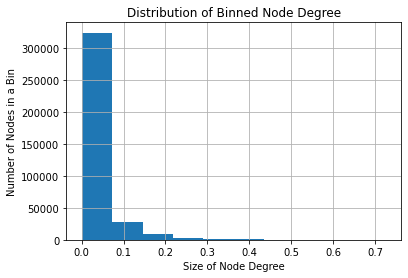

In [27]:
data_ari = abs(df[df['Future_Connection']>=0]['ARI'])
#print(node_sizes)
pd.DataFrame(data_ari).hist(bins=10)
# Add title and axis names
plt.title('Distribution of Binned Node Degree')
plt.xlabel('Size of Node Degree')
plt.ylabel('Number of Nodes in a Bin')
pyplot.show()

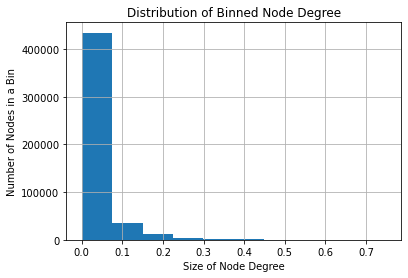

In [28]:
df['ARI'] = abs(df['ARI'])
pd.DataFrame(df['ARI']).hist(bins=10)
# Add title and axis names
plt.title('Distribution of Binned Node Degree')
plt.xlabel('Size of Node Degree')
plt.ylabel('Number of Nodes in a Bin')
pyplot.show()

Next we port the _Future\_Connection_ column to the y variable. 

Once the features and labeled are separated, we’re ready to split the data into train and test sets. This will separate 25%( default value) of the data into a subset for testing part and the remaining 75% will be used for our training subset.



In [29]:
train = df[df['Future_Connection']>=0]
train = train.drop('Conn',axis=1)
X = train.iloc[:,0:10]
y = train.iloc[:,10].astype('category')
print('X Size = {},  y size = {}'.format(X.shape, y.shape[0]))

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
print('X_train Size = {},  y_train size = {}'.format(X_train.shape, y_train.shape[0]))
print('X_val Size = {},  y_val size = {}'.format(X_val.shape, y_val.shape[0]))

#X_train = train.iloc[:,0:10]
#y_train = train.iloc[:,10].astype('category')

X_test = df[-(df['Future_Connection']>=0)]
edge_id = pd.DataFrame()
edge_id = pd.DataFrame(X_test['Conn'])

X_test = X_test.drop('Conn',axis=1)
X_test = X_test.drop('Future_Connection',axis=1)
print('X_test Size = {}'.format(X_test.shape))
X_val.head()

X Size = (366334, 10),  y size = 366334
X_train Size = (274750, 10),  y_train size = 274750
X_val Size = (91584, 10),  y_val size = 91584
X_test Size = (122112, 10)


,CNI,JCI,RAI,AAI,PAI,ARI,NDI,TNI,VDI,UDI
258076,3,0.030612,0.028175,0.640146,2565,0.009018,0.059235,101,57,45
257583,0,0.000000,0.000000,0.000000,200,0.009111,0.000000,53,50,4
386574,1,0.016393,0.002882,0.170960,903,0.005443,0.033278,62,43,21
219457,14,0.186667,0.260574,3.492987,2028,0.283561,0.310881,89,39,52
351673,0,0.000000,0.000000,0.000000,120,0.008102,0.000000,25,6,20


In [30]:
print('Connectioned Status Mean = {}%'.format(round(train['Future_Connection'].mean()*100,2)))

Connectioned Status Mean = 8.01%


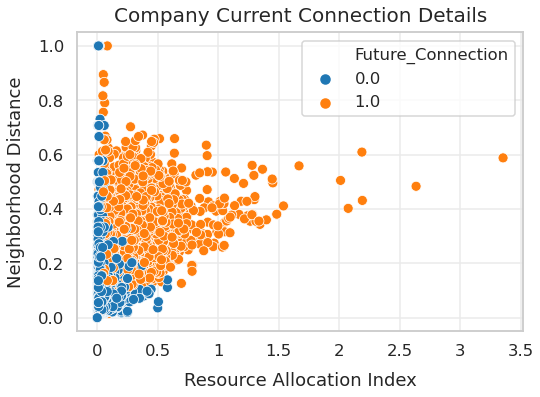

In [31]:
# Source: https://dfrieds.com/machine-learning/visual-introduction-classification-logistic-regression-python.html
sns.set_context("talk")
sns.set_style("whitegrid", {'grid.color': '.92'})

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)

    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")

    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]

    return new_tick_format

plt.figure(figsize=(8, 5.5))
sns.scatterplot(x='RAI', y='NDI', hue='Future_Connection', data=train, s=100)
plt.title("Company Current Connection Details", y=1.015, fontsize=20)
plt.xlabel("Resource Allocation Index", labelpad=13)
plt.ylabel("Neighborhood Distance", labelpad=13)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

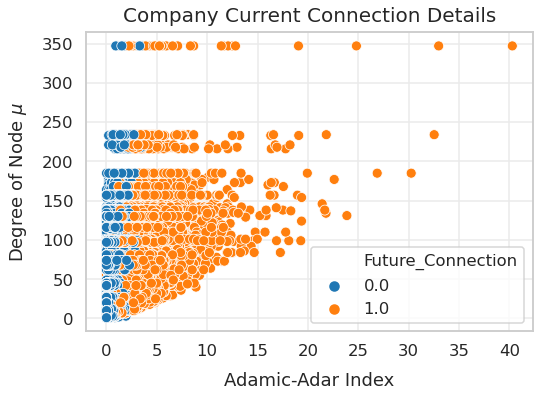

In [32]:
plt.figure(figsize=(8, 5.5))
sns.scatterplot(x='AAI', y='UDI', hue='Future_Connection', data=train, s=100)
plt.title("Company Current Connection Details", y=1.015, fontsize=20)
plt.xlabel("Adamic-Adar Index", labelpad=13)
plt.ylabel("Degree of Node $\mu$", labelpad=13)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

In [33]:
lrBlight = LogisticRegression(C=1).fit(X_train, y_train)  #00000000003
#dtBlight = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
print(lrBlight.intercept_)
print(lrBlight.coef_.round(4))
from sklearn.feature_selection import chi2
scores, pvalues = chi2(X_train, y_train)
pvalues

[-3.98132146]
[[ 5.145e-01  8.190e-02  1.364e-01  6.073e-01 -2.000e-04  1.296e-01
   1.533e-01 -1.011e-01  9.270e-02  9.020e-02]]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

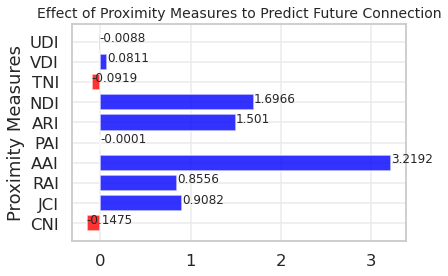

In [35]:
objects = ('CNI', 'JCI', 'RAI', 'AAI', 'PAI', 'ARI', 'NDI', 'TNI', 'VDI', 'UDI')
y_pos = np.arange(len(objects))
performance = [-0.1475,0.9082,0.8556,3.2192,-0.0001,1.501,1.6966,-0.0919,0.0811,-0.0088]
colors = []
for value in performance:
    if value >= 0:
        colors.append('blue')
    else:
        colors.append('red')
plt.barh(objects, performance, align='center', alpha = 0.8, color = colors)
plt.ylabel('Proximity Measures')
for index, value in enumerate(performance):
    plt.text(value, index, str(value), fontsize=12)
plt.title('Effect of Proximity Measures to Predict Future Connection', fontsize=14)

plt.show()

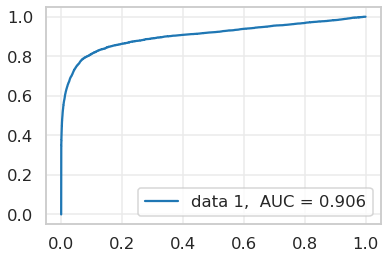

In [36]:
y_pred_proba = lrBlight.predict_proba(X_val)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_val,  y_pred_proba)
auc = metrics.roc_auc_score(y_val, y_pred_proba)
plt.plot(fpr,tpr,label="data 1,  AUC = "+str(round(auc,3)))
plt.legend(loc=4)
plt.show()

In [37]:
y_pred_proba = pd.DataFrame(y_pred_proba)
y_pred_proba

,0
0,0.035880
1,0.012496
2,0.020251
3,0.988758
4,0.015288
...,...
91579,0.046760
91580,0.017537
91581,0.007522
91582,0.027374


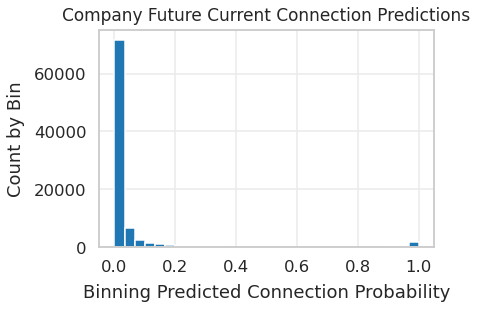

In [38]:
y_pred_proba.columns = ['Link_Pred_Prob']
plt.hist(y_pred_proba['Link_Pred_Prob'], bins=30)
plt.title("Company Future Current Connection Predictions", y=1.015, fontsize=17)
plt.xlabel("Binning Predicted Connection Probability", labelpad=9)
plt.ylabel("Count by Bin", labelpad=9)

pyplot.show()

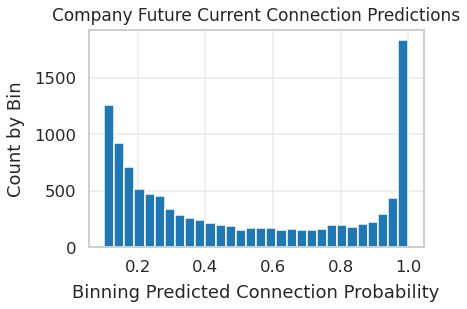

In [39]:
plt.hist(y_pred_proba[y_pred_proba['Link_Pred_Prob']>=0.1]['Link_Pred_Prob'], bins=30)
plt.title("Company Future Current Connection Predictions", y=1.015, fontsize=17)
plt.xlabel("Binning Predicted Connection Probability", labelpad=9)
plt.ylabel("Count by Bin", labelpad=9)

pyplot.show()

In [40]:
# make class predictions for the Validation set
y_pred_class = lrBlight.predict(X_val)

In [41]:
class_names = ["Not Connected", "Connected"]

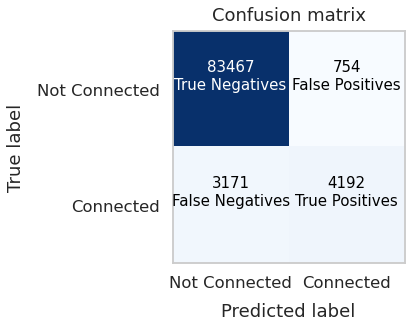

In [42]:
#Source: https://dfrieds.com/machine-learning/visual-introduction-classification-logistic-regression-python.html
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    name = None    
    fmt = 'd'
    thresh = cm.max() / 2
    # i and j tell us the coordinates of boxes
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 0 and j == 0:
            name = "True Negatives"
        elif i == 0 and j == 1:
            name = "False Positives"
        elif i == 1 and j == 1:
            name = "True Positives"
        else:
            name = "False Negatives"
        plt.text(j, i, format(cm[i, j], fmt) + "\n" + name, horizontalalignment="center", 
                 fontsize=15, color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', labelpad=12)
    plt.xlabel('Predicted label', labelpad=12)
    plt.title(title, y=1.02)
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_val, y_pred_class);
np.set_printoptions(precision=2);

# Plot non-normalized confusion matrix
plt.figure(figsize=(6, 6))
plt.grid(False)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix') #, without normalization')

In [43]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_val, y_pred_class)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[83467   754]
 [ 3171  4192]]


In [44]:
# calculate accuracy and Precision
print(metrics.accuracy_score(y_val, y_pred_class).round(3)*100)
print(metrics.precision_score(y_val, y_pred_class))

95.7
0.8475535786494137


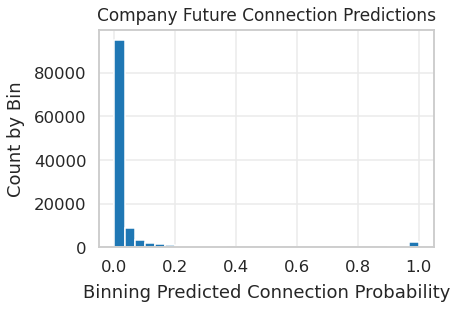

In [45]:
y_pred_prob_test = pd.DataFrame(lrBlight.predict_proba(X_test)[::,1])
y_pred_prob_test.columns = ['Link_Pred_Prob']
plt.hist(y_pred_prob_test['Link_Pred_Prob'], bins=30)
plt.title("Company Future Connection Predictions", y=1.015, fontsize=17)
plt.xlabel("Binning Predicted Connection Probability", labelpad=9)
plt.ylabel("Count by Bin", labelpad=9)

pyplot.show()

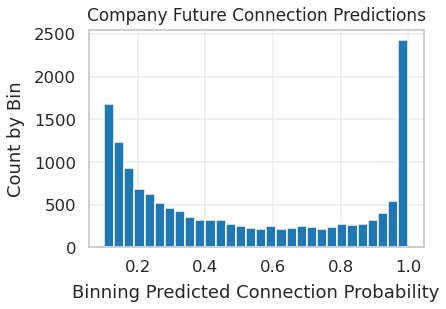

In [46]:
plt.hist(y_pred_prob_test[y_pred_prob_test['Link_Pred_Prob']>=0.1]['Link_Pred_Prob'], bins=30)
plt.title("Company Future Connection Predictions", y=1.015, fontsize=17)
plt.xlabel("Binning Predicted Connection Probability", labelpad=9)
plt.ylabel("Count by Bin", labelpad=9)

pyplot.show()

In [47]:
edge_id = edge_id.reset_index()

In [48]:
edge_id

,index,Conn
0,5,"(0, 9)"
1,13,"(0, 19)"
2,14,"(0, 20)"
3,29,"(0, 35)"
4,32,"(0, 38)"
...,...,...
122107,488425,"(998, 999)"
122108,488437,"(1000, 1002)"
122109,488438,"(1000, 1003)"
122110,488439,"(1000, 1004)"


In [49]:
y_pred_prob_test['Conn'] = None
y_pred_prob_test.update(edge_id)

In [50]:
y_pred_prob_test.head()

,Link_Pred_Prob,Conn
0,0.029400,"(0, 9)"
1,0.059764,"(0, 19)"
2,0.302499,"(0, 20)"
3,0.010494,"(0, 35)"
4,0.006898,"(0, 38)"


In [51]:
y_pred_prob_test['pos0'] = y_pred_prob_test['Conn'].str.find('(')
y_pred_prob_test['pos1'] = y_pred_prob_test['Conn'].str.find(',')
y_pred_prob_test['pos2'] = y_pred_prob_test['Conn'].str.find(')')

y_pred_prob_test['node_u'] = y_pred_prob_test.apply(lambda x: x['Conn'][x['pos0']+1:x['pos1']],axis=1)
y_pred_prob_test['node_v'] = y_pred_prob_test.apply(lambda x: x['Conn'][x['pos1']+2:x['pos2']],axis=1)

y_pred_prob_test[y_pred_prob_test['node_u']=='274'].head()

,Link_Pred_Prob,Conn,pos0,pos1,pos2,node_u,node_v
56496,0.018785,"(274, 275)",0,4,9,274,275
56497,0.064666,"(274, 288)",0,4,9,274,288
56498,0.207133,"(274, 290)",0,4,9,274,290
56499,0.231252,"(274, 300)",0,4,9,274,300
56500,0.695376,"(274, 301)",0,4,9,274,301


In [52]:
y_pred_prob_test[y_pred_prob_test['node_u']=='274'][y_pred_prob_test['Link_Pred_Prob']>0.5]

<ipython-input-52-2889455f930c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_pred_prob_test[y_pred_prob_test['node_u']=='274'][y_pred_prob_test['Link_Pred_Prob']>0.5]


,Link_Pred_Prob,Conn,pos0,pos1,pos2,node_u,node_v
56500,0.695376,"(274, 301)",0,4,9,274,301
56506,0.994966,"(274, 322)",0,4,9,274,322


<ipython-input-53-e1d9799b6cd5>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(y_pred_prob_test[y_pred_prob_test['node_u']=='274'][y_pred_prob_test['Link_Pred_Prob']>0.1]['Link_Pred_Prob'], bins=30)


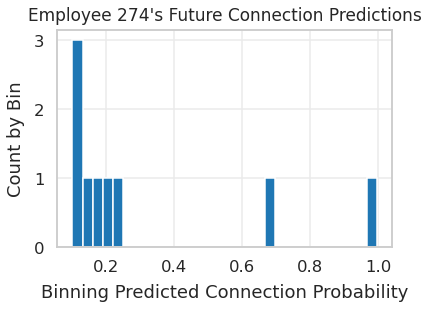

In [53]:
plt.hist(y_pred_prob_test[y_pred_prob_test['node_u']=='274'][y_pred_prob_test['Link_Pred_Prob']>0.1]['Link_Pred_Prob'], bins=30)
plt.title("Employee 274's Future Connection Predictions", y=1.015, fontsize=17)
plt.xlabel("Binning Predicted Connection Probability", labelpad=9)
plt.ylabel("Count by Bin", labelpad=9)
pyplot.show()

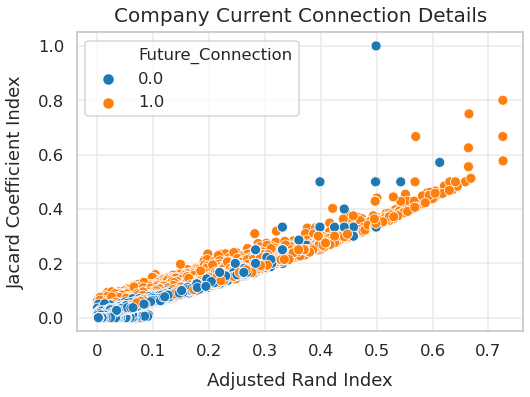

In [54]:
plt.figure(figsize=(8, 5.5))
sns.scatterplot(x='ARI', y='JCI', hue='Future_Connection', data=train, s=100)
plt.title("Company Current Connection Details", y=1.015, fontsize=20)
plt.xlabel("Adjusted Rand Index", labelpad=13)
plt.ylabel("Jacard Coefficient Index", labelpad=13)
ax = plt.gca()
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))

### Challenging Issues
- Due to the resulting computatioal burden, test set sampling is common in link prediction evaulation.  For such sampling, the challenge task is that, if it is not properly refective of the orgiginal distribution, can greatly increase the likelihood of biased evaluations that do not meaningfully indicate the true performance of link predictors.
- The selected evaluation metric can have a tremedous bearing on the apparent quality and ranking of predictors even with proper testing distributions.
- The directionality of links also introduces challenge issues that do not exist in typical classification tasks.
- For tasks involving network evoulation, such as predicting the appearance of links in the future, the classification process involves temporal aspects.

### References

 1. Hasan, Mohammad A., Vineet Chaoji, Saeed Salem, and Mohammed Zaki (2006) Link Prediction using Supervised Learning. In Proceedings of SDM Workshop of Link Analysis, Counterterrorism and Security.  
 2. Xu-Wen Wang, Yize Chen, and Yang-Yu Liu, Link Prediction through Deep Learning, The Preprint Server for Biology, https://doi.org/10.1101/247577  
 3. Anil A, Kumar D, Sharma S, Singha R, Sarmah R, Bhattacharya N, Singh S R, Link Prediction using Social Network Analysis over Heterogeneous Terrorist Network, 2015 IEEE Inter. Conf. on Smart City/SocialCom/SustainCom/DataCom 2015 and SC2 2015.  
 4. Berlusconi G, Calderoni F, Parolini N, Verani M, Piccardi C (2016), Link Prediction in Criminal Networks: A Tool for Criminal Intelligence Analysis. PLoS ONE 11(4): e0154244. doi:10.1371/ journal.pone.0154244  
 5. Yang Y, Lichtenwalter R, and Chawla N, “Evaluating Link Prediction Methods”, arXiv.org, Cornell University.  
 6. Daniel Romero, Applied Social Network Analysis in Python Course on Coursera  
 7. J. McAuley and J. Leskovec. Learning to Discover Social Circles in Ego Networks. NIPS, 2012.  
 8. Jason Brownlee, How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python, https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/  
 9. Precision-Recall, https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html  
 10. Raf Guns, Link prediction with the linkpred tool, Measuring scholarly impact: Methods and practice  
 11. M. Hasan, V. Chaoji, S. Salem, and M. Zaki, Link Prediction using Supervised Learning.  
 12. L. Pan, T. Zhou, L. Lü & C. Hu, Predicting missing links and identifying spurious links via likelihood analysis.  
 13. B. Chroł, M.Bojanowski, Proximity-based Methods for Link Prediction,                                       https://cran.r-project.org/web/packages/linkprediction/vignettes/proxfun.html  
 14. Logistic Regression in Machine Learning, https://www.javatpoint.com/logistic-regression-in-machine-learning  
 15. Guillaume Le Floch, Link Prediction In Large-Scale Networks, https://hackernoon.com/link-prediction-in-large-scale-networks-f836fcb05c88  
 16. Link Prediction UTS, https://www.kaggle.com/c/link-prediction-uts/overview  
 17. A Guide to Link Prediction – How to Predict your Future Connections on Facebook, https://www.kaggle.com/c/link-prediction-uts/overview  
 18. Logistic Regression – A Complete Tutorial With Examples in R, https://www.machinelearningplus.com/machine-learning/logistic-regression-tutorial-examples-r/